# Train Data Preparation (With K-means)

Now we prepare the training data for model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import os

In [2]:
index_component_start = pd.read_excel("data/20150101-20150520.xlsx", sheet_name="行业")
stocks = index_component_start["代码"].to_list()
index_component_change = pd.read_excel("data/index_adjustment.xlsx")
stocks_ch = index_component_change["代码"].to_list()
index_component = list(set(stocks + stocks_ch))

We set time 2021-03-01 to 2022-03-11 as our backtesting period. So, the training set is the first 1497 data in the stock datas.

## Use K-means to cluster the stocks
We first use K-means to cluster the stocks based on their return type. This can help us to build more suitable model for each clustered category of stocks.

In [3]:
cluster_data = pd.DataFrame()
for com in tqdm(index_component):
    data = pd.read_csv(f"featured_stock/{com[:6]}.csv")[["time", "code", "Target"]][:1497]
    data['time'] = pd.to_datetime(data['time'])
    cluster_data = pd.concat([cluster_data, data], axis=0)
cluster_data.reset_index(drop=True)

100%|██████████| 111/111 [00:02<00:00, 46.06it/s]


,time,code,Target
0,2015-01-05,601318,-0.012999
1,2015-01-06,601318,0.018853
2,2015-01-07,601318,0.005994
3,2015-01-08,601318,0.109595
4,2015-01-09,601318,0.074822
...,...,...,...
152784,2021-02-22,600029,-0.020602
152785,2021-02-23,600029,-0.056836
152786,2021-02-24,600029,0.003165
152787,2021-02-25,600029,0.012924


Now we start the K-means clustering, and cluster the stocks into 5 categories.

In [4]:
from sklearn.cluster import KMeans
cluster_p = cluster_data.pivot(index='time', columns='code', values='Target')
cluster_p = cluster_p.sort_index()

In [5]:
corr = cluster_p.corr()
corr = corr.replace(np.NaN, 0)
ids = corr.index

In [7]:
kmeans = KMeans(n_clusters=5, random_state=615).fit_predict(corr.values)
print(kmeans)

[4 1 2 4 4 2 4 4 2 0 2 4 4 2 2 2 4 0 2 2 1 2 1 1 2 1 2 2 3 1 3 1 1 1 2 2 4
 1 2 2 1 1 3 2 1 3 0 1 2 1 1 4 0 0 4 1 0 4 4 2 0 4 4 4 0 0 1 1 4 3 4 4 4 4
 1 0 4 4 4 4 1 4 4 0 0 2 3 4 0 4 4 4 4 0 0 1 2 0 2 4 1 4 2 1 4 3 3 1 3 3 2]


In [9]:
corr

code,600000,600009,600010,600015,600016,600018,600019,600028,600029,600030,...,601988,601989,601995,601998,603160,603259,603288,603501,603986,603993
code,,,,,,,,,,,,,,,,,,,,,
600000,1.000000,0.342191,0.372284,0.668069,0.633444,0.376265,0.409335,0.471941,0.376809,0.516676,...,0.580769,0.323792,0.190628,0.616584,0.132921,0.095885,0.196167,0.162655,0.176356,0.303095
600009,0.342191,1.000000,0.334026,0.315352,0.317367,0.435188,0.355741,0.360777,0.492218,0.378233,...,0.316016,0.373606,0.425418,0.315252,0.081445,0.103475,0.323972,0.141912,0.063381,0.333049
600010,0.372284,0.334026,1.000000,0.340016,0.364628,0.514558,0.566173,0.422634,0.399147,0.444352,...,0.411915,0.490972,-0.155746,0.409572,0.095210,-0.057439,0.111666,0.088188,0.128978,0.463783
600015,0.668069,0.315352,0.340016,1.000000,0.704783,0.402784,0.433425,0.564822,0.397401,0.566548,...,0.670670,0.405344,0.288827,0.679080,0.145387,0.144305,0.151244,0.103138,0.092670,0.272834
600016,0.633444,0.317367,0.364628,0.704783,1.000000,0.405207,0.460692,0.551132,0.354909,0.547991,...,0.671473,0.295919,0.386984,0.692190,0.103350,0.081775,0.203632,0.143082,0.163142,0.264089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603259,0.095885,0.103475,-0.057439,0.144305,0.081775,0.085537,0.071785,0.056792,0.102838,0.179801,...,0.066155,0.036928,0.213945,0.119752,0.134881,1.000000,0.322623,0.210980,0.027941,0.183604
603288,0.196167,0.323972,0.111666,0.151244,0.203632,0.104977,0.157014,0.169470,0.226566,0.292376,...,0.195506,0.100019,0.176714,0.240320,0.058210,0.322623,1.000000,0.138641,0.010678,0.185785
603501,0.162655,0.141912,0.088188,0.103138,0.143082,0.171587,0.047902,0.105209,0.119609,0.233920,...,0.043675,0.165319,0.216229,0.066524,0.318787,0.210980,0.138641,1.000000,0.363033,0.125885


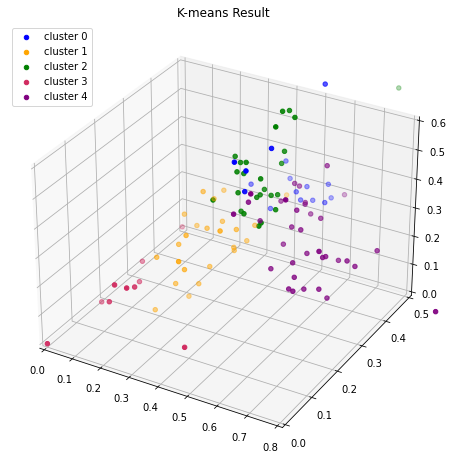

In [14]:
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['axes.facecolor']='white'

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.axes.set_xlim3d(left=0.0, right=0.8) 
ax.axes.set_ylim3d(bottom=0.0, top=0.5) 
ax.axes.set_zlim3d(bottom=0.0, top=0.6) 
ax.scatter3D(corr.iloc[0][kmeans == 0], corr.iloc[10][kmeans == 0], corr.iloc[100][kmeans == 0], color = 'blue', label = "cluster 0")
ax.scatter3D(corr.iloc[0][kmeans == 1], corr.iloc[10][kmeans == 1], corr.iloc[100][kmeans == 1], color = 'orange', label = "cluster 1")
ax.scatter3D(corr.iloc[0][kmeans == 2], corr.iloc[10][kmeans == 2], corr.iloc[100][kmeans == 2], color = 'green', label = "cluster 2")
ax.scatter3D(corr.iloc[0][kmeans == 3], corr.iloc[10][kmeans == 3], corr.iloc[100][kmeans == 3], color = '#D12B60', label = "cluster 3")
ax.scatter3D(corr.iloc[0][kmeans == 4], corr.iloc[10][kmeans == 4], corr.iloc[100][kmeans == 4], color = 'purple', label = "cluster 4")
ax.legend()
plt.title("K-means Result")
plt.savefig("plot1")

In [8]:
stock_list1 = []
stock_list2 = []
stock_list3 = []
stock_list4 = []
stock_list5 = []
for i in range(len(kmeans.labels_)):
    if kmeans.labels_[i] == 0:
        stock_list1.append(ids[i])
    elif kmeans.labels_[i] == 1:
        stock_list2.append(ids[i])
    elif kmeans.labels_[i] == 2:
        stock_list3.append(ids[i])
    elif kmeans.labels_[i] == 3:
        stock_list4.append(ids[i])
    elif kmeans.labels_[i] == 4:
        stock_list5.append(ids[i])
stock_type = [stock_list1, stock_list2, stock_list3, stock_list4, stock_list5]

In [9]:
print(f"{stock_type[0]} are clustered to type 0.")
print(f"{stock_type[1]} are clustered to type 1.")
print(f"{stock_type[2]} are clustered to type 2.")
print(f"{stock_type[3]} are clustered to type 3.")
print(f"{stock_type[4]} are clustered to type 4.")

[600030, 600109, 600837, 600958, 600999, 601066, 601138, 601198, 601211, 601377, 601669, 601688, 601788, 601878, 601881, 601901] are clustered to type 0.
[600009, 600196, 600276, 600309, 600340, 600438, 600518, 600519, 600547, 600588, 600690, 600703, 600809, 600887, 600900, 600918, 601012, 601229, 601236, 601360, 601633, 601888, 601985, 601995, 603288] are clustered to type 1.
[600010, 600018, 600029, 600031, 600050, 600089, 600100, 600111, 600150, 600256, 600332, 600372, 600406, 600570, 600583, 600606, 600637, 600795, 600893, 601118, 601727, 601899, 601919, 601989, 603993] are clustered to type 2.
[600436, 600485, 600745, 600832, 601299, 601728, 603160, 603259, 603501, 603986] are clustered to type 3.
[600000, 600015, 600016, 600019, 600028, 600036, 600048, 600104, 600585, 600919, 601006, 601088, 601111, 601166, 601169, 601186, 601288, 601318, 601319, 601328, 601336, 601390, 601398, 601601, 601628, 601658, 601668, 601766, 601800, 601816, 601818, 601857, 601939, 601988, 601998] are clu

Now, we start to prepare training data for model building based on the stock types.

In [10]:
def training_data_type(type):
    """
    merge the training dataset based on stock types
    """
    training_data = pd.DataFrame()
    for i in stock_type[type]:
        data = pd.read_csv(f"featured_stock/{i}.csv").drop(["time", "code"], axis=1)[:1497]
        data = data.dropna(axis=0)
        training_data = pd.concat([training_data, data], axis=0)
    training_data.reset_index(drop=True)
    return training_data

Store the training data.

In [11]:
for t in [0,1,2,3,4]:
    train = training_data_type(t)
    train.to_csv(f"TrainingData/StockType{t}.csv", index=False)

In [12]:
for i in [0,1,2,3,4]:
    np.savetxt(f'TrainingData/stocktype{i}.txt',stock_type[i],delimiter="\n", fmt="%s")

Try to load type back.

In [14]:
from numpy import loadtxt
#read text file into NumPy array
data = loadtxt('TrainingData/stocktype0.txt')

In [15]:
int(data[0])

600030